# A simple application of a Hamiltonian Monte-Carlo (HMC) algorithm.

`Arthur Loureiro - UCL PAD Feb/2019`

> Based on http://people.duke.edu/~ccc14/sta-663-2018/notebooks/S10E_HMC.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as plt
from functools import partial
import seaborn as sns
import scipy.linalg as la

np.random.seed(123)

## Let's create some target distribution we want to properly sample with HMC. 

Let us use a bi-variate Gaussian distribution centered at zero: 
### $x \sim \mathcal{G}(0,\Sigma)$

In this first simple example, let us "ignore" the dependency on the data. The potential energy is then given by: 
### $\psi(x) = \frac{x^T\Sigma^{-1}x}{2}$
while the kinectic energy of the system is (here, we consider the mass to be unity): 
### $K(p) = \frac{p^tp}{2}$

The Hamiltonian of such system is simply:
### $H(x,p) = \psi(x) + K(p) = \frac{x^T\Sigma^{-1}x}{2} + \frac{p^tp}{2}$


## The target distribution looks like:


[-3.5, 3.5, -3.5, 3.5]

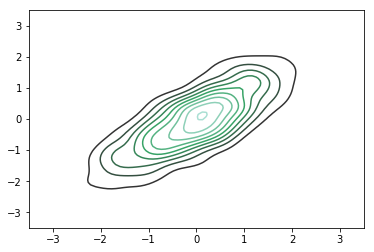

In [16]:
sigma = np.array([[1,0.8],[0.8,1]])
mu = np.zeros(2)
ys = np.random.multivariate_normal(mu, sigma, 1000)
sns.kdeplot(ys[:,0], ys[:,1])
plt.axis([-3.5,3.5,-3.5,3.5])

## The total energy of the system after evolving the system to the proposed set of new points $(x^*,p^*)$ is given by $\delta H = H(x,p) - H(x^*,p^*)$

In [3]:
# let's write the energy of the system...
def E(tau, x0, p0, x, p):
    """Total energy."""
    return (x0 @ tau @ x0 + p0 @ v0) - (x @ tau@x + p @ p)

## From Hamilton's Equations, one has:

## $\frac{dx}{dt} = \frac{\partial H(x,p)}{\partial p} = \frac{\partial K(p)}{\partial p}$
## $\frac{dp}{dt} = \frac{\partial H(x,p)}{\partial x} = \frac{\partial \psi(x)}{\partial x}$

To evolve these equations, we'll use a simple integration method, like the leap-frog method. The algorithm is quite simple:
1. Half a time step for the momenta, $p_{n+1/2}$
2. Full time step for the positions, $x_{n+1}$
3. A final half time step for the momenta, $p_{n+1}$

## Guiding the algorithm
A good practice is to use the gradient of the potencial energy to "guide" the proposal distribution:
### $A = \begin{pmatrix} 0 & 1 \\ -\Sigma^{-1} & 0 \end{pmatrix}$
This matrix will be guiding the step-size for the Leap-frog integration.


In [7]:
# using leap-frog to evolve the system
def leapfrog(A, x, p, h, N):
    """Leapfrog finite difference scheme."""
    p = p - h/2 * A @ x
    for i in range(N-1):
        x = x + h * p
        p = p - h * A @ x

    x = x + h * p
    p = p - h/2 * A @ u

    return x, p

## Inicializing some important variables to start the sampler:

In [30]:
# number of samples:
niter = 150

# This is a free parameter that controls the acceptance ratio:
h = 0.01

# Number of steps in the leap-frog integration:
N = 100

# step size = sigma^-1:
tau = la.inv(sigma)

# inicializing the trajectories:
orbit = np.zeros((niter+1, 2))

# inicial position:
x = np.array([-3,3])
orbit[0] = x


## Now let's perform the HCM:

[-3.5, 3.5, -3.5, 3.5]

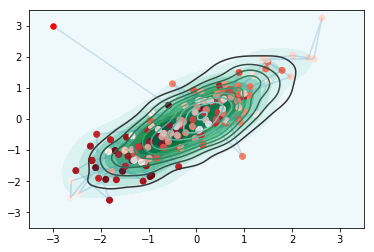

In [34]:
for k in range(niter):
    # the inicial momenta can be sampled from a normal distr:
    p0 = np.random.normal(0,1,2)
    x, p = leapfrog(tau, x, p0, h, N)

    # accept-reject
    x0 = orbit[k]
    a = np.exp(E(tau, x0, p0, x, p))
    r = np.random.rand()

    if r < a:
        orbit[k+1] = x
    else:
        orbit[k+1] = x0
        
# and plot:
sns.kdeplot(orbit[:, 0], orbit[:, 1],shade=True)
sns.kdeplot(ys[:,0], ys[:,1])
plt.plot(orbit[:,0], orbit[:,1], alpha=0.2)
plt.scatter(orbit[:1,0], orbit[:1,1],  c='red', s=30)
plt.scatter(orbit[1:,0], orbit[1:,1],  c=np.arange(niter)[::-1], cmap='Reds')
plt.axis([-3.5,3.5,-3.5,3.5])

# Let us now try a more realistic example!

## First, let's create some fake data! 
(based on the [emcee tutorial](https://emcee.readthedocs.io/en/latest/tutorials/line/))

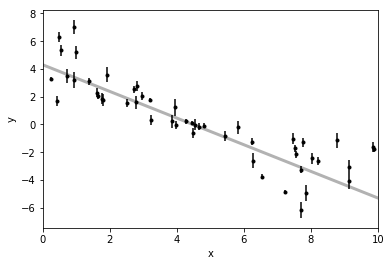

In [35]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");